In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import warnings
import statsmodels.api as sm
import yfinance as yf
warnings.filterwarnings("ignore")
list_ = pd.read_csv("../database/tw_maincode_etf__2025.csv")
tw_etf_code_list = list_['code'].values
price = pd.read_parquet("../database/tw_price.parquet")
etf_price = price[price['code'].isin(tw_etf_code_list)]
# tester
# etf_price[etf_price['code'] == "0050 TT Equity"].sort_values(by='da')[['da', "cl"]].set_index("da").plot()

op_df = etf_price.pivot_table(index='da', columns="code", values='op')
hi_df = etf_price.pivot_table(index='da', columns="code", values='hi')
lo_df = etf_price.pivot_table(index='da', columns="code", values='lo')
cl_df = etf_price.pivot_table(index='da', columns="code", values='cl')
vol_df = etf_price.pivot_table(index='da', columns="code", values='vol')
to_df = etf_price.pivot_table(index='da', columns="code", values='turnover')
etf_price.columns

Index(['da', 'code', 'cl', 'hi', 'lo', 'op', 'adj', 'avg_cl', 'vol', 'vol_net',
       'avg_count', 'avg_count_net', 'trade_count', 'turnover'],
      dtype='object')

In [20]:
pct_close_w = cl_df.pct_change().dropna(how='all').resample("ME").sum()['2017-01-01':]

In [3]:

indexes = pct_close_w.index
tickers = pct_close_w.iloc[:, :].columns
indices = indexes[12:]
forecast = np.zeros((len(indices), len(tickers)))
print(indices[0])
for index, date in enumerate(tqdm(indices, desc=f"arma model for top {len(tickers)}, enumerate by da")):
    pct_train = pct_close_w.loc[indexes[index]:date]
    for i in range(len(tickers)):
        series = pct_train[tickers[i]]
        if series.isna().any():
            prediction = 0
            print(tickers[i], "failed at", date)
            continue
            ###### ARIMA ma
        else:
            model = sm.tsa.arima.ARIMA(series, order=(2, 0, 0))
            model_fit = model.fit()
            prediction = model_fit.forecast().values[0]
        forecast[index, i] = prediction
factor = pd.DataFrame(forecast, columns=tickers, index=indices)


2017-03-31 00:00:00


arma model for top 280, enumerate by da: 100%|██████████| 409/409 [28:03<00:00,  4.12s/it]


In [21]:
from arch import arch_model
indexes = pct_close_w.index
tickers = pct_close_w.iloc[:, :].columns
indices = indexes[12:]
print(indices)
forecast = np.zeros((len(indices), len(tickers)))
for index, date in enumerate(tqdm(indices, desc=f"arma model for top {len(tickers)}, enumerate by da")):
    pct_train = pct_close_w.loc[indexes[index]:date]
    for i in range(len(tickers)):
        series = pct_train[tickers[i]]
        if series.isna().any():
            prediction = 0
            print(tickers[i], "failed at", date)
            continue
            ###### ARIMA ma
        else:
            model = arch_model(series, p=2)
            model_fit = model.fit(disp='off')
            prediction = model_fit.forecast().variance.values[0][0]
        forecast[index, i] = prediction
factor = pd.DataFrame(forecast, columns=tickers, index=indices)


DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
      

arma model for top 280, enumerate by da:   0%|          | 0/85 [00:00<?, ?it/s]/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message

In [26]:
factor.to_parquet("garch_tw_etf_280_2017_2018_monthly.parquet")

<Axes: title={'center': '10 quantile cumsum distribution'}, xlabel='da'>

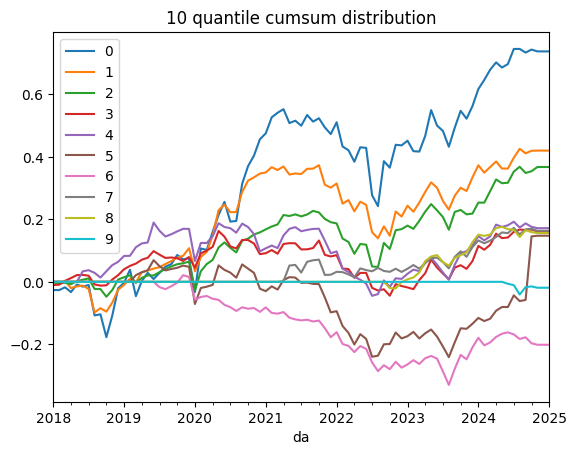

In [27]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
quantile = 10
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-2)

index = factor.index
list_corr = []
list_short_corr = []
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
    weighting_1 = _reweighting_equal(df_1)
    ret = pct_close_w_corres.loc[weighting_1.index[0]:] * weighting_1
    quantiles[qt_iter] = ret.sum(axis=1).cumsum()

quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.plot(title="10 quantile cumsum distribution")

In [39]:
factor = pd.read_parquet("tw_etf_280_2017_2018_weekly.parquet")

<Axes: title={'center': '10 quantile cumsum distribution'}, xlabel='da'>

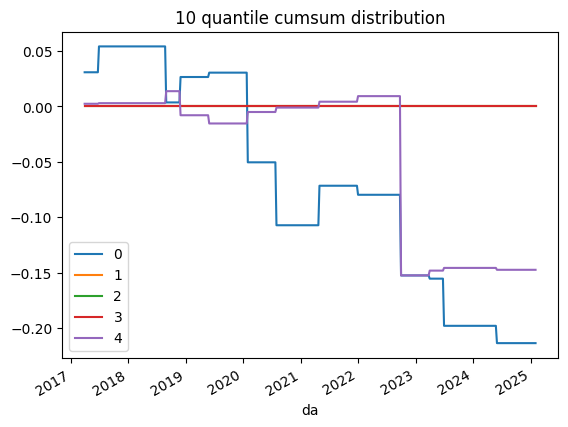

In [42]:
vol_df_w = vol_df.resample("W-FRI").last()
# Step 1: Filter factor to keep only top 50 volume stocks for each day
factor_filtered = factor.copy()
for date in factor.index:
    top_50_stocks = vol_df_w.loc[date].nlargest(50).index  # Get top 50 volume stocks
    factor_filtered.loc[date, ~factor_filtered.columns.isin(top_50_stocks)] = 0  # Zero out others

# Step 2: Compute the demeaned weighting
weighting = get_demean_weighting(factor_filtered)

# Step 3: Compute equal weighting
weighting_equal = _reweighting_equal(weighting)

# Step 4: Proceed with your quantile-based portfolio construction
quantile = 5
time_length = len(factor_filtered)
quantile_column = [[None] * quantile] * time_length
quantile_df = pd.DataFrame(quantile_column)

for da in range(time_length):
    row = factor_filtered.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i * int(len(row) / quantile):(i + 1) * int(len(row) / quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor_filtered.columns)].shift(-2)

index = factor_filtered.index
list_corr = []
list_short_corr = []
quantiles = [None] * quantile

for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor_filtered.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
    weighting_1 = _reweighting_equal(df_1)
    ret = pct_close_w_corres.loc[weighting_1.index[0]:] * weighting_1
    quantiles[qt_iter] = ret.sum(axis=1).cumsum()

quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.plot(title="10 quantile cumsum distribution")


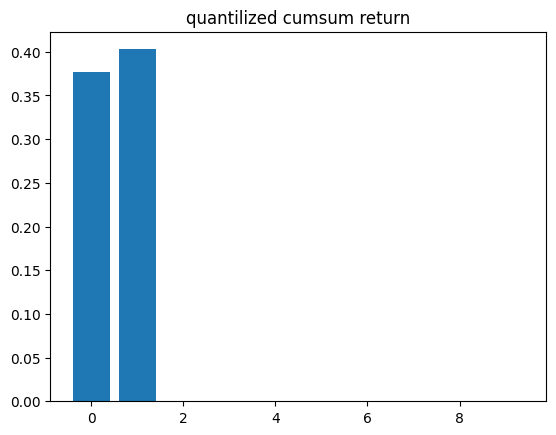

In [37]:
"""
0: AR預測值最高; 9: 最低 (number of stocks in thje stock pool: 1013; stocks per quantile: 100, 等權做多報酬)
"""
plt.bar(quantilized_cumsum.columns, quantilized_cumsum.iloc[-1, :])
plt.title("quantilized cumsum return")
plt.show()


In [ ]:
# implementing ARMA from scratch
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

def ar2_forecast(series):
    pass

In [17]:
def generate_ar2_series(n=200, phi1=0.7, phi2=-0.3, noise_std=0.02):
    """Generate an AR(2) time series."""
    np.random.seed(42)
    series = np.zeros(n)
    noise = np.random.randn(n) * noise_std  # Random noise

    # Start with small random values
    series[0] = noise[0]
    series[1] = phi1 * series[0] + noise[1]

    for t in range(2, n):
        series[t] = phi1 * series[t - 1] + phi2 * series[t - 2] + noise[t]

    return series

series = generate_ar2_series()

In [18]:
def generate_trended_seasonal_series(n=200, trend=0.0005, seasonality_amp=0.02, noise_std=0.01):
    """Generate a random series with trend and seasonality."""
    np.random.seed(42)
    time = np.arange(n)
    seasonal_component = seasonality_amp * np.sin(2 * np.pi * time / 30)  # Monthly cycle
    noise = np.random.randn(n) * noise_std
    series = trend * time + seasonal_component + noise  # Trend + Seasonality + Noise
    return series

dates = pd.date_range("2020-01-01", periods=200, freq="D")
trended_series = generate_trended_seasonal_series()

df_trended = pd.DataFrame(trended_series, index=dates, columns=["Trended + Seasonal Series"])
print(df_trended.head())

            Trended + Seasonal Series
2020-01-01                   0.004967
2020-01-02                   0.003276
2020-01-03                   0.015612
2020-01-04                   0.028486
2020-01-05                   0.014521


In [33]:
if isinstance(series, np.ndarray): pass
if isinstance(series, pd.Series): series.to_numpy()
y = series
len(y[:-2])


198